In [3]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [39]:
runs_dir = "/home/jovyan/sophie/runs/final_gs/arch_seg"

In [93]:
curr_run.scalars.Keys()

['Loss/train',
 'Precision/test',
 'Recall/test',
 'F1/test',
 'AUC/test',
 'Precision/ext1',
 'Recall/ext1',
 'F1/ext1',
 'AUC/ext1',
 'Precision/ext2',
 'Recall/ext2',
 'F1/ext2',
 'AUC/ext2',
 'Precision/ext3',
 'Recall/ext3',
 'F1/ext3',
 'AUC/ext3']

In [45]:
run_df = pd.DataFrame()
mean_df = pd.DataFrame()

training_method = "full_network"
backbone_list = os.listdir("/home/jovyan/sophie/runs/final_gs/arch_seg/{}".format(training_method))

for backbone in backbone_list:
    run_pth = os.path.join(runs_dir, training_method, backbone)
    run_list = os.listdir(run_pth)
    for run in run_list:
        curr_run = EventAccumulator(path=os.path.join(run_pth,run))
        curr_run.Reload()
        join_df = pd.DataFrame()
        
        join_df['Step'] = [i.step for i in curr_run.Scalars("F1/test")]
        join_df['F1/Test'] = [i.value for i in curr_run.Scalars("F1/test")]
        join_df['F1/Ext1'] = [i.value for i in curr_run.Scalars("F1/ext1")]
        join_df['F1/Ext2'] = [i.value for i in curr_run.Scalars("F1/ext2")]
        join_df['F1/Ext3'] = [i.value for i in curr_run.Scalars("F1/ext3")]

        join_df['AUC/Test'] = [i.value for i in curr_run.Scalars("AUC/test")]
        join_df['AUC/Ext1'] = [i.value for i in curr_run.Scalars("AUC/ext1")]
        join_df['AUC/Ext2'] = [i.value for i in curr_run.Scalars("AUC/ext2")]
        join_df['AUC/Ext3'] = [i.value for i in curr_run.Scalars("AUC/ext3")]

        join_df['Recall/Test'] = [i.value for i in curr_run.Scalars("Recall/test")]
        join_df['Recall/Ext1'] = [i.value for i in curr_run.Scalars("Recall/ext1")]
        join_df['Recall/Ext2'] = [i.value for i in curr_run.Scalars("Recall/ext2")]
        join_df['Recall/Ext3'] = [i.value for i in curr_run.Scalars("Recall/ext3")]

        join_df['Backbone'] = run_pth.split("/")[-1]
        join_df['Training'] = run_pth.split("/")[-2]
        join_df['Image'] = run_pth.split("/")[-3]
        
        join_df['Seed'] = run.split("_")[7]
        
        join_df['LR'] = run.split("_")[1]
        join_df['Batch'] = run.split("_")[3]
        join_df['Mom'] = run.split("_")[5]

        run_df = pd.concat([run_df,join_df])

        

In [177]:
full_network_df = pd.DataFrame()
training = "full_network"
for backbone in run_df.Backbone.unique():
    for seed in run_df.Seed.unique():
        sample_df  = run_df.query("Backbone=='{}' & Training=='{}' & Seed=='{}'".format(backbone, training, seed)).copy()
        for col_name in ["F1/Test","F1/Ext1","F1/Ext2","F1/Ext3",\
                         "AUC/Test","AUC/Ext1","AUC/Ext2","AUC/Ext3",\
                         # "Precision/Test","Precision/Ext1","Precision/Ext2","Precision/Ext3",\
                         "Recall/Test","Recall/Ext1","Recall/Ext2","Recall/Ext3",\
                        ]:
            sample_df["{}_SMA".format(col_name)] = sample_df[col_name].rolling(15).mean()
        full_network_df = pd.concat([full_network_df,sample_df])
    

In [185]:
full_network_df.columns

Index(['Step', 'F1/Test', 'F1/Ext1', 'F1/Ext2', 'F1/Ext3', 'AUC/Test',
       'AUC/Ext1', 'AUC/Ext2', 'AUC/Ext3', 'Recall/Test', 'Recall/Ext1',
       'Recall/Ext2', 'Recall/Ext3', 'Backbone', 'Training', 'Image', 'Seed',
       'LR', 'Batch', 'Mom', 'F1/Test_SMA', 'F1/Ext1_SMA', 'F1/Ext2_SMA',
       'F1/Ext3_SMA', 'AUC/Test_SMA', 'AUC/Ext1_SMA', 'AUC/Ext2_SMA',
       'AUC/Ext3_SMA', 'Recall/Test_SMA', 'Recall/Ext1_SMA', 'Recall/Ext2_SMA',
       'Recall/Ext3_SMA'],
      dtype='object')

In [197]:
dum = full_network_df[['Step','F1/Ext1_SMA', 'F1/Ext2_SMA',
       'F1/Ext3_SMA','Backbone', 'Training','Seed']].copy()
# remove first empty rows from averaging process
dum = dum.dropna(axis=0,how="any").reset_index(drop=True)
# pivot seed into new cols
dum = dum.pivot_table(
    index=['Step', 'Backbone', 'Training'],
    columns='Seed',
    values=['F1/Ext1_SMA', 'F1/Ext2_SMA', 'F1/Ext3_SMA']
).reset_index()

# flatten and rename cols
dum.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in dum.columns]
dum = dum.rename(columns=lambda x: x.replace('_', '') if 'Step' in x or 'Backbone' in x or 'Training' in x else x)

metrics = ['F1/Ext1_SMA', 'F1/Ext2_SMA', 'F1/Ext3_SMA']
for metric in metrics:
    seed_columns = [f'{metric}_{seed}' for seed in [41, 42, 43]]
    dum[f'{metric}_Mean'] = dum[seed_columns].mean(axis=1)
    # dum.drop(columns=seed_columns, inplace=True)

# ================================
dum_auc = full_network_df[['Step','AUC/Ext1_SMA', 'AUC/Ext2_SMA',
       'AUC/Ext3_SMA','Backbone', 'Training','Seed']].copy()
# remove first empty rows from averaging process
dum_auc = dum_auc.dropna(axis=0,how="any").reset_index(drop=True)
# pivot seed into new cols
dum_auc = dum_auc.pivot_table(
    index=['Step', 'Backbone', 'Training'],
    columns='Seed',
    values=['AUC/Ext1_SMA', 'AUC/Ext2_SMA', 'AUC/Ext3_SMA']
).reset_index()

# flatten and rename cols
dum_auc.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in dum_auc.columns]
dum_auc = dum_auc.rename(columns=lambda x: x.replace('_', '') if 'Step' in x or 'Backbone' in x or 'Training' in x else x)

metrics = ['AUC/Ext1_SMA', 'AUC/Ext2_SMA', 'AUC/Ext3_SMA']
for metric in metrics:
    seed_columns = [f'{metric}_{seed}' for seed in [41, 42, 43]]
    dum_auc[f'{metric}_Mean'] = dum_auc[seed_columns].mean(axis=1)
    # dum.drop(columns=seed_columns, inplace=True)


In [184]:
dum.columns

Index(['Step', 'Backbone', 'Training', 'F1/Ext1_SMA_41', 'F1/Ext1_SMA_42',
       'F1/Ext1_SMA_43', 'F1/Ext2_SMA_41', 'F1/Ext2_SMA_42', 'F1/Ext2_SMA_43',
       'F1/Ext3_SMA_41', 'F1/Ext3_SMA_42', 'F1/Ext3_SMA_43',
       'F1/Ext1_SMA_Mean', 'F1/Ext2_SMA_Mean', 'F1/Ext3_SMA_Mean'],
      dtype='object')

<Axes: xlabel='Step', ylabel='Value'>

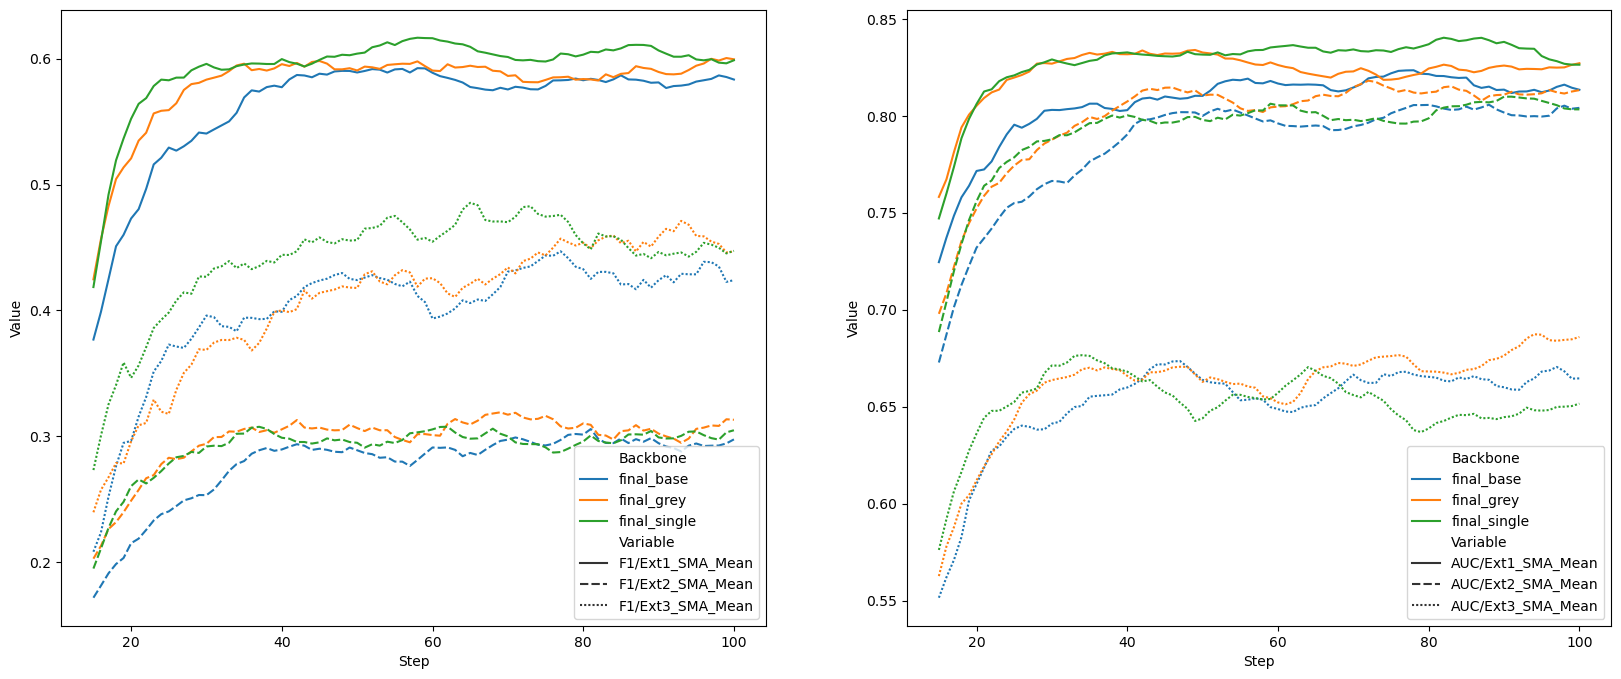

In [209]:
fig, axes = plt.subplots(1, 2,figsize=(20,8))

sns.lineplot(dum[['Step','Backbone','Training','F1/Ext1_SMA_Mean','F1/Ext2_SMA_Mean','F1/Ext3_SMA_Mean']].melt(id_vars=['Step','Backbone','Training'],var_name="Variable",value_name="Value"),
            x= 'Step', y='Value', hue='Backbone', style='Variable',ax=axes[0])

sns.lineplot(dum_auc[['Step','Backbone','Training','AUC/Ext1_SMA_Mean','AUC/Ext2_SMA_Mean','AUC/Ext3_SMA_Mean']].melt(id_vars=['Step','Backbone','Training'],var_name="Variable",value_name="Value"),
            x= 'Step', y='Value', hue='Backbone', style='Variable',ax=axes[1])

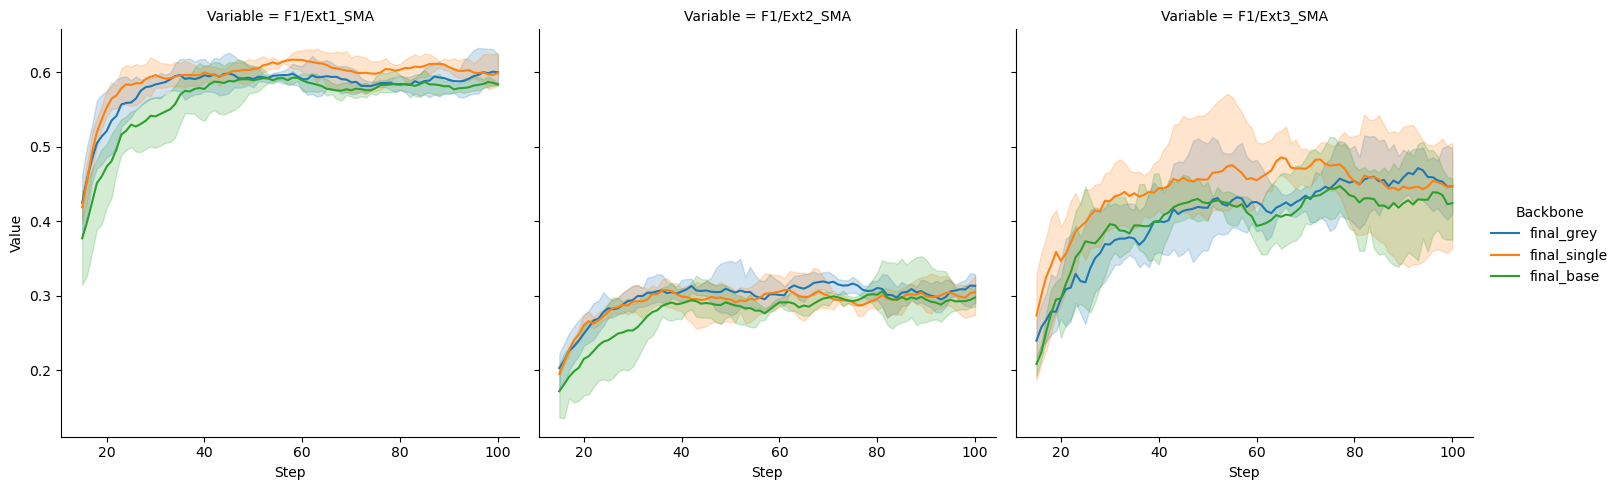

In [216]:
# fig, axes = plt.subplots(1, 1,figsize=(20,6))

sns.relplot(data=full_network_df[['Step','F1/Ext1_SMA', 'F1/Ext2_SMA',
       'F1/Ext3_SMA','Backbone', 'Training','Seed']].melt(
    id_vars=['Step','Backbone','Training','Seed'],var_name="Variable",value_name="Value").dropna(axis=0,how="any").reset_index(drop=True),
            x="Step", y="Value", hue="Backbone", kind="line", col='Variable')

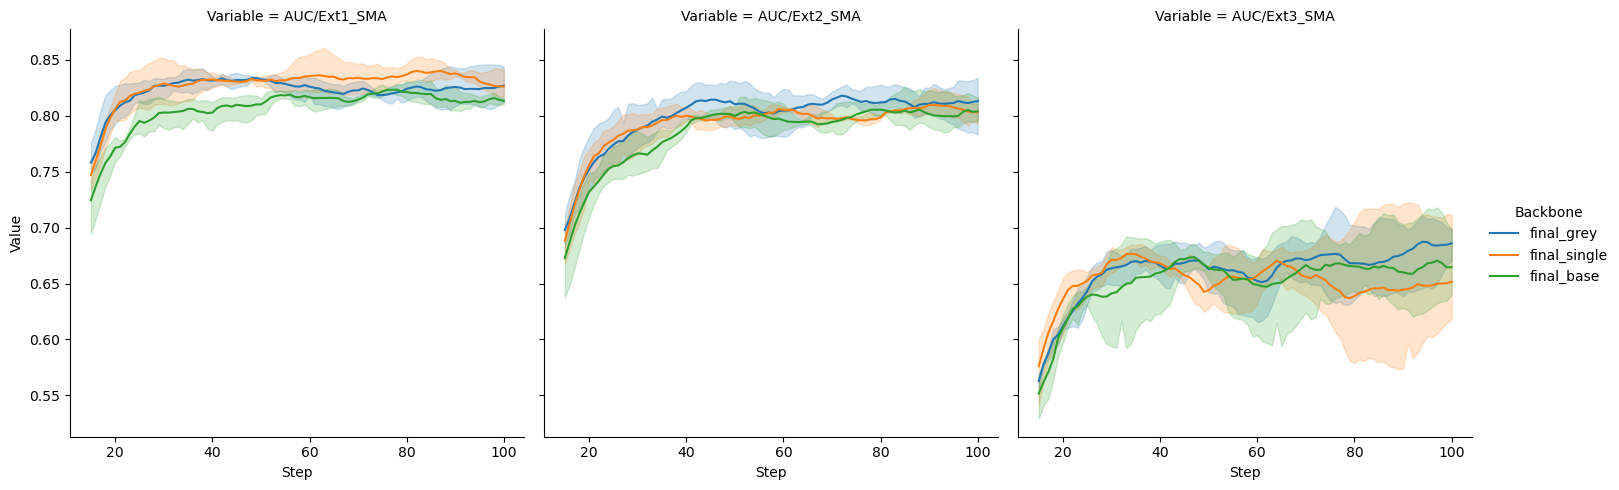

In [198]:
sns.relplot(data=full_network_df[['Step','AUC/Ext1_SMA', 'AUC/Ext2_SMA',
       'AUC/Ext3_SMA','Backbone', 'Training','Seed']].melt(
    id_vars=['Step','Backbone','Training','Seed'],var_name="Variable",value_name="Value").dropna(axis=0,how="any").reset_index(drop=True),
            x="Step", y="Value", hue="Backbone", kind="line", col='Variable')

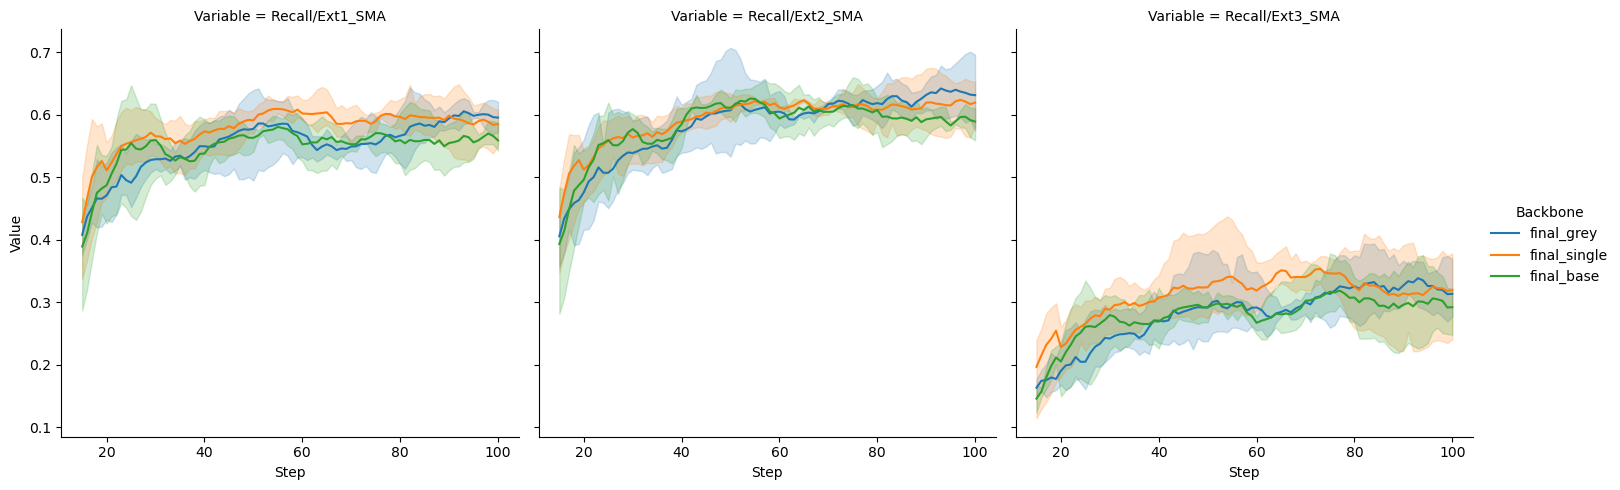

In [199]:
sns.relplot(data=full_network_df[['Step','Recall/Ext1_SMA', 'Recall/Ext2_SMA',
       'Recall/Ext3_SMA','Backbone', 'Training','Seed']].melt(
    id_vars=['Step','Backbone','Training','Seed'],var_name="Variable",value_name="Value").dropna(axis=0,how="any").reset_index(drop=True),
            x="Step", y="Value", hue="Backbone", kind="line", col='Variable')

In [50]:
full_grey = run_df[(run_df['Backbone'] == 'final_grey') & (run_df['Training'] == 'full_network')]
full_single = run_df[(run_df['Backbone'] == 'final_single') & (run_df['Training'] == 'full_network')]
full_base = run_df[(run_df['Backbone'] == 'final_base') & (run_df['Training'] == 'full_network')]

In [74]:
long_full_f1_df = full_grey[['Step','F1/Test', 'F1/Ext1', 'F1/Ext2', 'F1/Ext3']].melt(id_vars='Step',var_name="Variable",value_name="Value")
long_full_f1_df['Weights'] = "Grey"
long_full_f1_df= pd.concat([long_full_f1_df,full_single[['Step','F1/Test', 'F1/Ext1', 'F1/Ext2', 'F1/Ext3']].melt(id_vars='Step',var_name="Variable",value_name="Value")])
long_full_f1_df['Weights'] = long_full_f1_df['Weights'].fillna("Single")
long_full_f1_df= pd.concat([long_full_f1_df,full_base[['Step','F1/Test', 'F1/Ext1', 'F1/Ext2', 'F1/Ext3']].melt(id_vars='Step',var_name="Variable",value_name="Value")])
long_full_f1_df['Weights'] = long_full_f1_df['Weights'].fillna("Base")


In [79]:
long_full_f1_df.head()

,Step,Variable,Value,Weights
0,1,F1/Test,0.101523,Grey
1,2,F1/Test,0.000000,Grey
2,3,F1/Test,0.517460,Grey
3,4,F1/Test,0.438662,Grey
4,5,F1/Test,0.443580,Grey


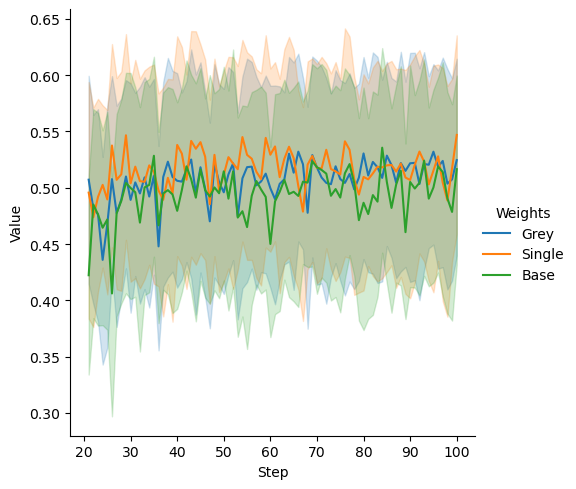

In [90]:
sns.relplot(data=long_full_f1_df.query("Step>20"), x="Step", y="Value", hue="Weights", kind="line")

In [264]:
pr_df = pd.DataFrame()
for run_name in good_runs.log_paths:
    curr_run = EventAccumulator(path=os.path.join(runs_dir,run_name))
    curr_run.Reload()
    join_df = pd.DataFrame()
    join_df['Step'] = [i.step for i in curr_run.Scalars("Precision/test")]
    join_df['Precision/Test'] = [i.value for i in curr_run.Scalars("Precision/test")]
    join_df['Recall/Test'] = [i.value for i in curr_run.Scalars("Recall/test")]

    join_df['Precision/Ext1'] = [i.value for i in curr_run.Scalars("Precision/ext1")]
    join_df['Precision/Ext2'] = [i.value for i in curr_run.Scalars("Precision/ext2")]
    join_df['Precision/Ext3'] = [i.value for i in curr_run.Scalars("Precision/ext3")]
        
    join_df['Recall/Ext1'] = [i.value for i in curr_run.Scalars("Recall/ext1")]
    join_df['Recall/Ext2'] = [i.value for i in curr_run.Scalars("Recall/ext2")]
    join_df['Recall/Ext3'] = [i.value for i in curr_run.Scalars("Recall/ext3")]
    
    join_df['Model'] = run_name.strip("224_runs/")
    join_df['Image'] = run_name.split("/")[1]
    join_df['Training'] = run_name.split("/")[2]
    join_df['Backbone'] = run_name.split("/")[3]
    join_df['LR'] = run_name.split("/")[4].split("_")[1]
    join_df['Batch'] = run_name.split("/")[4].split("_")[3]
    join_df['Mom'] = run_name.split("/")[4].split("_")[5]
    join_df['Subset'] = "-".join(run_name.split("/")[1:4])
    pr_df = pd.concat([pr_df,join_df])


In [268]:
pr_df[pr_df['Subset']==subset]

,Step,Precision/Test,Recall/Test,Precision/Ext1,Precision/Ext2,Precision/Ext3,Recall/Ext1,Recall/Ext2,Recall/Ext3,Model,Image,Training,Backbone,LR,Batch,Mom,Subset
0,1,0.736334,0.652422,0.872404,0.968037,0.387097,0.717073,0.769510,0.857143,lung_seg/half_network/grey89/lr_0.001_bsz_16_m...,lung_seg,half_network,grey89,0.001,16,0.99,lung_seg-half_network-grey89
1,2,0.669941,0.971510,0.815109,0.953833,0.375000,1.000000,0.993648,0.964286,lung_seg/half_network/grey89/lr_0.001_bsz_16_m...,lung_seg,half_network,grey89,0.001,16,0.99,lung_seg-half_network-grey89
2,3,0.731343,0.698006,0.843750,0.959135,0.392857,0.790244,0.724138,0.785714,lung_seg/half_network/grey89/lr_0.001_bsz_16_m...,lung_seg,half_network,grey89,0.001,16,0.99,lung_seg-half_network-grey89
3,4,0.683897,0.980057,0.818000,0.956140,0.378378,0.997561,0.989111,1.000000,lung_seg/half_network/grey89/lr_0.001_bsz_16_m...,lung_seg,half_network,grey89,0.001,16,0.99,lung_seg-half_network-grey89
4,5,0.728285,0.931624,0.841438,0.960748,0.362319,0.970732,0.932849,0.892857,lung_seg/half_network/grey89/lr_0.001_bsz_16_m...,lung_seg,half_network,grey89,0.001,16,0.99,lung_seg-half_network-grey89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,26,0.757991,0.945869,0.858696,0.964929,0.406250,0.963415,0.923775,0.928571,lung_seg/half_network/grey89/lr_0.01_bsz_16_mo...,lung_seg,half_network,grey89,0.01,16,0.95,lung_seg-half_network-grey89
26,27,0.882562,0.706553,0.910769,0.970724,0.478261,0.721951,0.571688,0.785714,lung_seg/half_network/grey89/lr_0.01_bsz_16_mo...,lung_seg,half_network,grey89,0.01,16,0.95,lung_seg-half_network-grey89
27,28,0.767816,0.951567,0.856540,0.966919,0.391304,0.990244,0.928312,0.964286,lung_seg/half_network/grey89/lr_0.01_bsz_16_mo...,lung_seg,half_network,grey89,0.01,16,0.95,lung_seg-half_network-grey89
28,29,0.736842,0.957265,0.846154,0.967105,0.405797,0.992683,0.933757,1.000000,lung_seg/half_network/grey89/lr_0.01_bsz_16_mo...,lung_seg,half_network,grey89,0.01,16,0.95,lung_seg-half_network-grey89


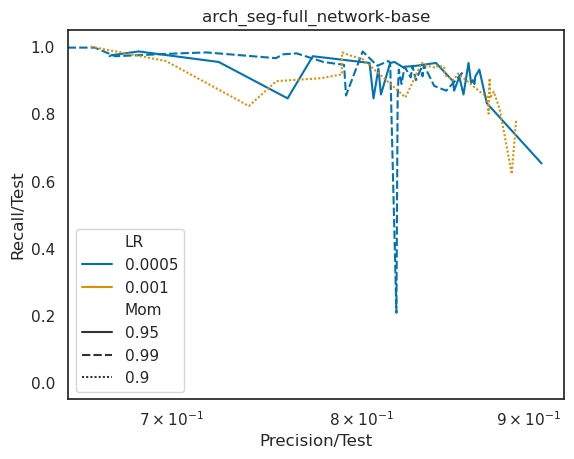

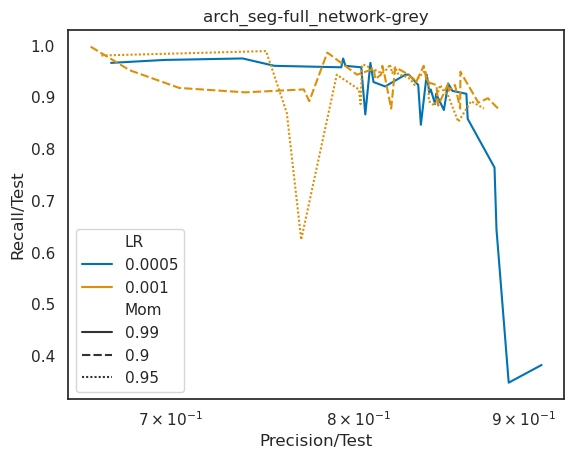

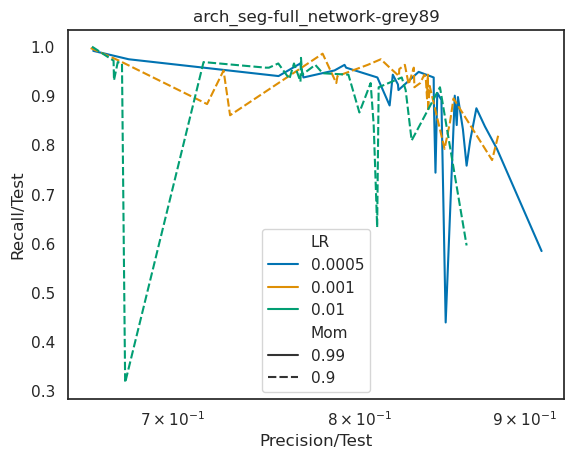

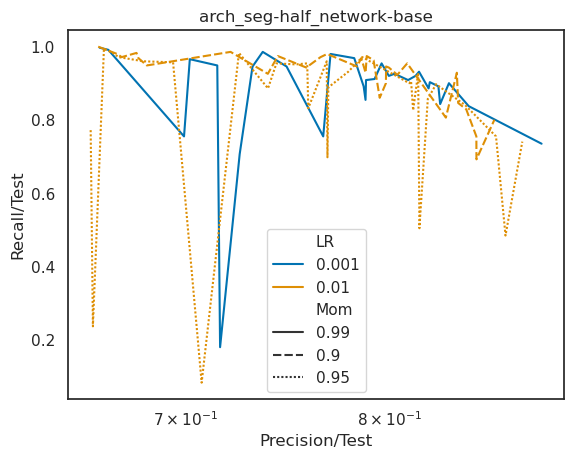

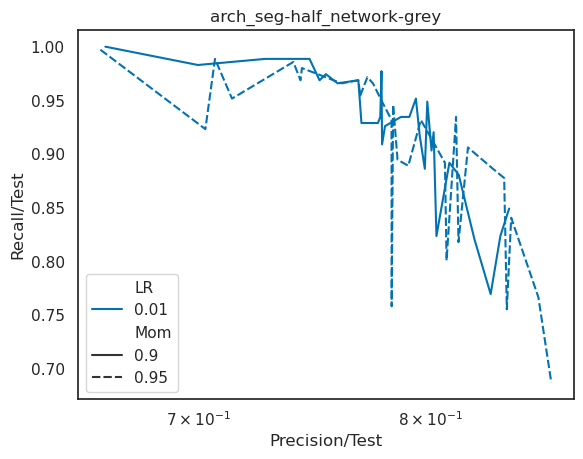

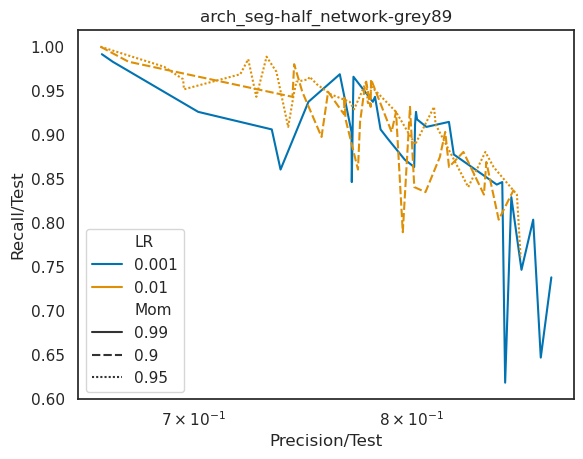

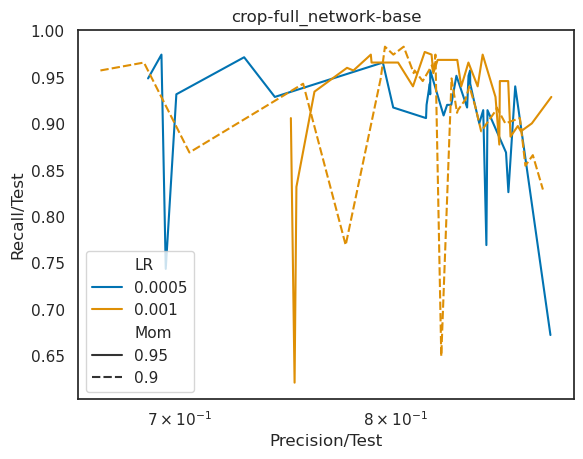

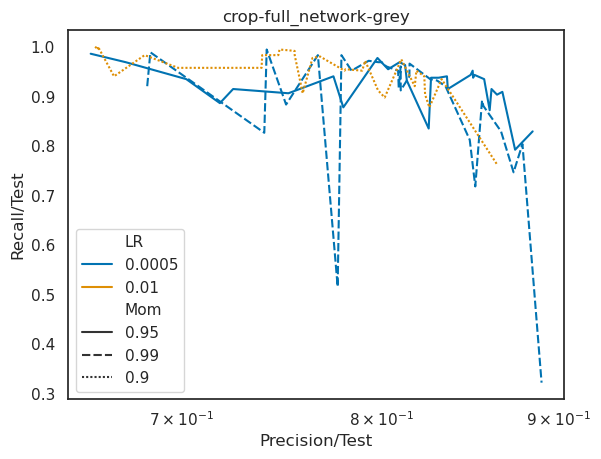

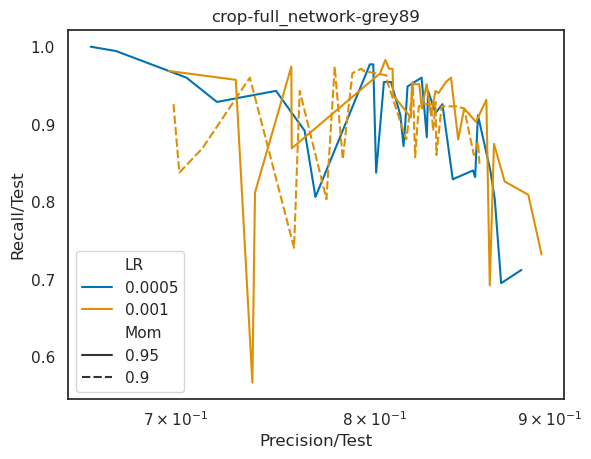

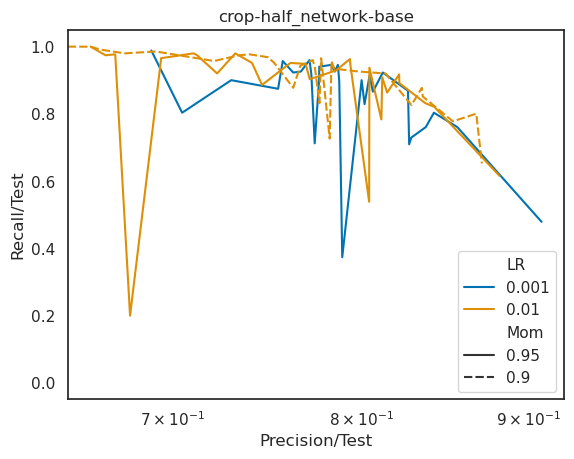

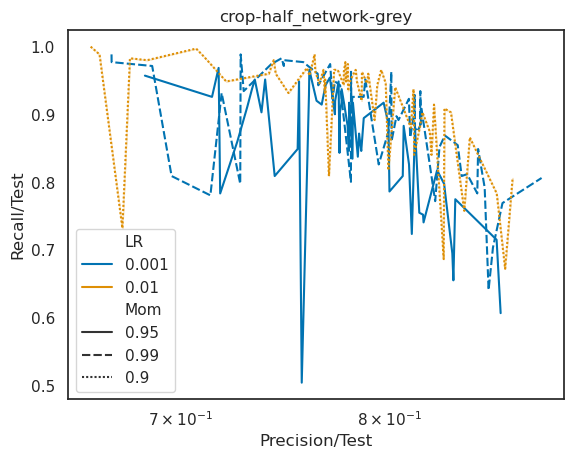

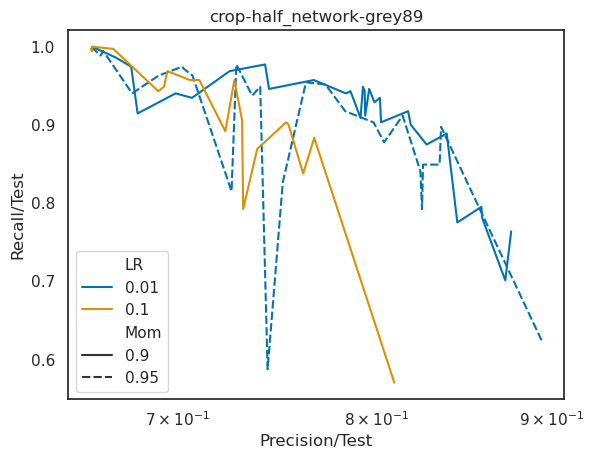

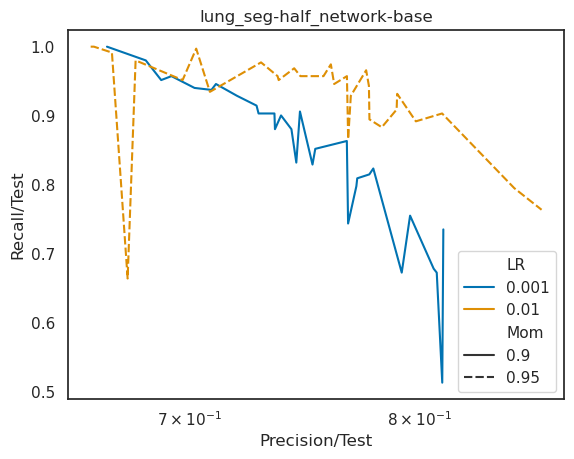

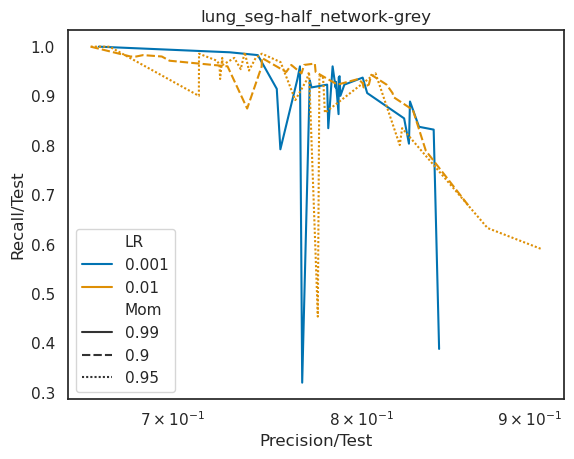

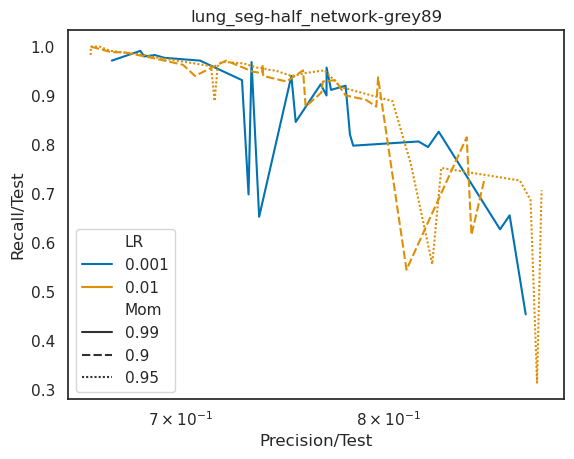

In [273]:
for subset in pr_df['Subset'].unique():
    fig, ax = plt.subplots()
    ax.set(xscale="log")
    sns.lineplot(data=pr_df[pr_df['Subset']==subset],
               x='Precision/Test',y='Recall/Test',
                 hue="LR",
                 style="Mom",
                 # ax = ax
              )
    plt.title("{}".format(subset))
    plt.show()